In [1]:
from tqdm import tqdm
import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [2]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.2.3 @ https://github.com/MedMNIST/MedMNIST/


In [3]:
# data_flag = 'pathmnist'
data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 50
BATCH_SIZE = 32
learning_rate = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [4]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /home/caesar/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/caesar/.medmnist/breastmnist.npz


In [5]:
(x_train, y_train) = (train_dataset.imgs, train_dataset.labels)
(x_test, y_test) = (test_dataset.imgs, test_dataset.labels)

In [6]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset BreastMNIST (breastmnist)
    Number of datapoints: 546
    Root location: /home/caesar/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST (breastmnist)
    Number of datapoints: 156
    Root location: /home/caesar/.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'm

In [7]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [8]:
x_train.shape, x_test.shape

((546, 28, 28), (156, 28, 28))

In [9]:
x_train = x_train.reshape((len(x_train), 28, 28, 1))
x_test = x_test.reshape((len(x_test), 28, 28, 1))

In [10]:
x_train.shape, x_test.shape

((546, 28, 28, 1), (156, 28, 28, 1))

In [11]:
# Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow
import tensorflow as tf

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')

2024-01-20 19:02:50.794707: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-20 19:02:50.820481: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-20 19:02:50.820508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-20 19:02:50.821137: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-20 19:02:50.825582: I tensorflow/core/platform/cpu_feature_guar

In [12]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
import numpy as np
import matplotlib.pyplot as plt
tf.__version__
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Reshape, Flatten


autoencoder = Sequential()

# Encoder
autoencoder.add(Conv2D(filters = 16, kernel_size=(3,3), activation='relu', padding='valid', input_shape=(28,28,1)))
autoencoder.add(MaxPooling2D(pool_size=(2,2)))

autoencoder.add(Conv2D(filters = 8, kernel_size=(3,3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#autoencoder.summary()

autoencoder.add(Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding = 'same', strides=(2,2)))

autoencoder.add(Flatten())

#autoencoder.summary()

# Decoder

autoencoder.add(Reshape((4,4,8)))
#autoencoder.summary()
autoencoder.add(Conv2D(filters = 8, kernel_size=(3,3), activation='relu', padding='same'))
#autoencoder.summary()
autoencoder.add(UpSampling2D(size=(2,2)))
#autoencoder.summary()

autoencoder.add(Conv2D(filters = 8, kernel_size=(3,3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D(size=(2,2)))

autoencoder.add(Conv2D(filters = 16, kernel_size=(3,3), activation='relu'))
autoencoder.add(UpSampling2D(size=(2,2)))

autoencoder.add(Conv2D(filters = 1, kernel_size=(3,3), activation='sigmoid', padding='same'))
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 8)           584       
                                                                 
 flatten (Flatten)           (None, 128)               0

In [13]:
autoencoder.compile(optimizer='Adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [14]:
autoencoder.fit(x_train, x_train, epochs = 50)

Epoch 1/50
 1/18 [>.............................] - ETA: 13s - loss: 0.6965 - accuracy: 0.0000e+00

2024-01-20 19:02:52.781442: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe9a0014e60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-01-20 19:02:52.781479: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-01-20 19:02:52.799229: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1705795372.907634   78645 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-01-20 19:02:52.908840: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-01-20 19:02:52.941526: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-01-20 19:02:52.970235: E external/local_xla/xl

18/18 [==============================] - 1s 9ms/step - loss: 0.6887 - accuracy: 1.7287e-04
Epoch 2/50
 8/18 [============>.................] - ETA: 0s - loss: 0.6641 - accuracy: 1.4947e-05

2024-01-20 19:02:52.987958: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


18/18 [==============================] - 0s 8ms/step - loss: 0.6516 - accuracy: 1.7287e-04
Epoch 3/50
18/18 [==============================] - 0s 8ms/step - loss: 0.5990 - accuracy: 1.7287e-04
Epoch 4/50
18/18 [==============================] - 0s 8ms/step - loss: 0.5819 - accuracy: 1.6820e-04
Epoch 5/50
18/18 [==============================] - 0s 8ms/step - loss: 0.5717 - accuracy: 1.7287e-04
Epoch 6/50
18/18 [==============================] - 0s 8ms/step - loss: 0.5650 - accuracy: 1.7521e-04
Epoch 7/50
18/18 [==============================] - 0s 8ms/step - loss: 0.5576 - accuracy: 1.7754e-04
Epoch 8/50
18/18 [==============================] - 0s 8ms/step - loss: 0.5534 - accuracy: 1.7754e-04
Epoch 9/50
18/18 [==============================] - 0s 8ms/step - loss: 0.5514 - accuracy: 1.7754e-04
Epoch 10/50
18/18 [==============================] - 0s 8ms/step - loss: 0.5495 - accuracy: 1.7754e-04
Epoch 11/50
18/18 [==============================] - 0s 8ms/step - loss: 0.5484 - accuracy: 

2024-01-20 19:02:56.204166: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


18/18 [==============================] - 0s 14ms/step - loss: 0.5441 - accuracy: 1.7754e-04
Epoch 24/50
18/18 [==============================] - 0s 14ms/step - loss: 0.5441 - accuracy: 1.7754e-04
Epoch 25/50
18/18 [==============================] - 0s 15ms/step - loss: 0.5436 - accuracy: 1.7754e-04
Epoch 26/50
 1/18 [>.............................] - ETA: 0s - loss: 0.5276 - accuracy: 0.0014

2024-01-20 19:02:56.992971: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


18/18 [==============================] - 0s 15ms/step - loss: 0.5434 - accuracy: 1.7754e-04
Epoch 27/50
18/18 [==============================] - 0s 14ms/step - loss: 0.5433 - accuracy: 1.7754e-04
Epoch 28/50
18/18 [==============================] - 0s 15ms/step - loss: 0.5431 - accuracy: 1.7754e-04
Epoch 29/50
18/18 [==============================] - 0s 14ms/step - loss: 0.5429 - accuracy: 1.7754e-04
Epoch 30/50
18/18 [==============================] - 0s 14ms/step - loss: 0.5428 - accuracy: 1.7988e-04
Epoch 31/50
18/18 [==============================] - 0s 14ms/step - loss: 0.5429 - accuracy: 1.7988e-04
Epoch 32/50
18/18 [==============================] - 0s 14ms/step - loss: 0.5428 - accuracy: 1.7754e-04
Epoch 33/50
18/18 [==============================] - 0s 14ms/step - loss: 0.5426 - accuracy: 1.7988e-04
Epoch 34/50
18/18 [==============================] - 0s 8ms/step - loss: 0.5424 - accuracy: 1.7988e-04
Epoch 35/50
18/18 [==============================] - 0s 8ms/step - loss: 0.54

In [15]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 8)           584       
                                                                 
 flatten (Flatten)           (None, 128)               0

In [16]:
encoder = Model(inputs = autoencoder.input, outputs = autoencoder.get_layer('flatten').output)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 8)           584   

In [17]:
# coded_test_images = encoder.predict(x_test)
coded_test_images = encoder.predict(x_train)

18/18 [==============================] - 0s 2ms/step


In [18]:
coded_test_images.shape

(546, 128)

In [19]:
coded_test_images[0]

array([0.23903024, 0.1729876 , 0.        , 0.10271996, 0.        ,
       0.2796702 , 0.        , 0.35381496, 0.38543165, 0.15079816,
       0.15319015, 0.        , 0.09385206, 0.560352  , 0.07992586,
       0.49295607, 0.43309143, 0.14263873, 0.13714288, 0.        ,
       0.15674742, 0.4986863 , 0.07868288, 0.44199222, 0.3838135 ,
       0.1442887 , 0.24164   , 0.        , 0.09695195, 0.6607166 ,
       0.30675882, 0.28379518, 0.3264544 , 0.15077779, 0.        ,
       0.24045578, 0.        , 0.39966372, 0.        , 0.7788776 ,
       0.568278  , 0.04571054, 0.31739002, 0.18780112, 0.23152305,
       0.7043665 , 0.        , 0.96762824, 0.6146795 , 0.00532955,
       0.3104851 , 0.238121  , 0.26216054, 0.6415996 , 0.        ,
       0.828467  , 0.44661108, 0.10789138, 0.49491447, 0.        ,
       0.15041414, 0.78881764, 0.19520833, 0.40665853, 0.2705053 ,
       0.05118087, 0.        , 0.43422118, 0.02584694, 0.45095733,
       0.        , 0.68581283, 0.42009822, 0.        , 0.29740

In [20]:
decoded_test_images = autoencoder.predict(x_test)
decoded_test_images.shape

5/5 [==============================] - 0s 4ms/step


(156, 28, 28, 1)

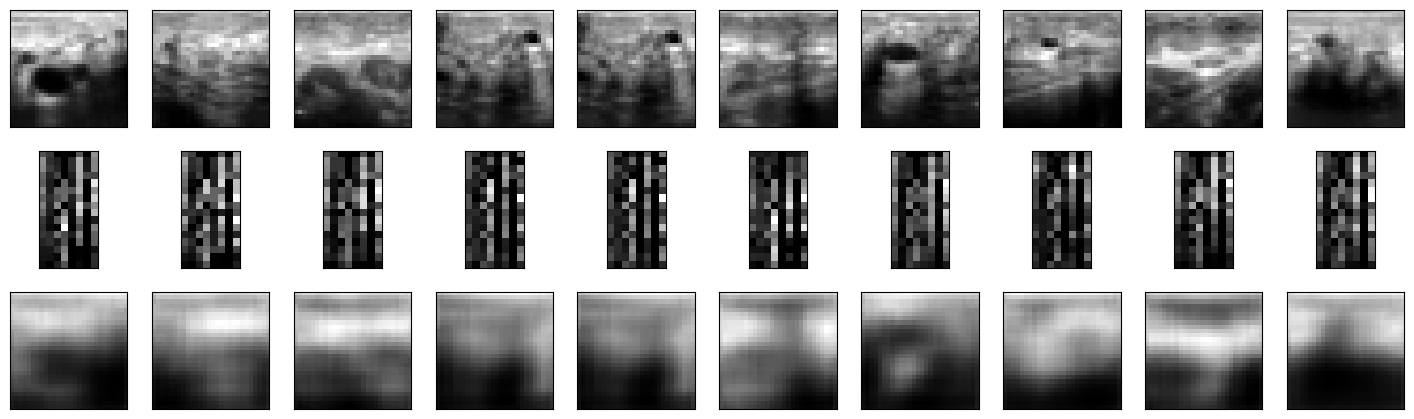

In [21]:
n_images = 10
test_images = np.random.randint(0, x_test.shape[0], size = n_images)
plt.figure(figsize=(18,18))
for i, image_index in enumerate(test_images):
  # Original images
  ax = plt.subplot(10,10, i + 1)
  plt.imshow(x_test[image_index].reshape(28,28), cmap='gray')
  plt.xticks(())
  plt.yticks(())

  # Coded images
  ax = plt.subplot(10,10, i + 1 + n_images)
  plt.imshow(coded_test_images[image_index].reshape(16,8), cmap='gray')
  plt.xticks(())
  plt.yticks(())

  # Decoded images
  ax = plt.subplot(10,10, i + 1 + n_images * 2)
  plt.imshow(decoded_test_images[image_index].reshape(28,28), cmap='gray')
  plt.xticks(())
  plt.yticks(())

In [22]:
X_train = encoder.predict(x_train)
X_test = encoder.predict(x_test)

5/5 [==============================] - 0s 4ms/step


In [23]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(546, 128)
(156, 128)
(546, 1)
(156, 1)


In [24]:
from sklearn.feature_selection import SelectKBest, f_classif

num_features = 64
selector = SelectKBest(f_classif, k=num_features)
X_train_new = selector.fit_transform(X_train, y_train.ravel())

# Transform both training and test data
X_train_new = selector.transform(X_train)
X_test_new = selector.transform(X_test)

print("New shape of training data: ", X_train_new.shape)
print("New shape of test data: ", X_test_new.shape)

New shape of training data:  (546, 64)
New shape of test data:  (156, 64)


/home/caesar/.local/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 38  46  54  70  86 102 110 118 126] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/caesar/.local/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [25]:
X_train = X_train_new
X_test = X_test_new

In [26]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [27]:
# Run a binary SVC classifier
# Create and fit the model

# Define the parameter ranges
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': ['scale', 'auto',100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
              'degree': [3, 6, 9, 13],
              'kernel': ['rbf', 'linear', 'poly']} 

grid = GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=3)

grid.fit(X_train, y_train.ravel())

Fitting 5 folds for each of 540 candidates, totalling 2700 fits
[CV 1/5] END C=0.1, degree=3, gamma=scale, kernel=rbf;, score=0.727 total time=   0.0s
[CV 2/5] END C=0.1, degree=3, gamma=scale, kernel=rbf;, score=0.734 total time=   0.0s
[CV 3/5] END C=0.1, degree=3, gamma=scale, kernel=rbf;, score=0.734 total time=   0.0s
[CV 4/5] END C=0.1, degree=3, gamma=scale, kernel=rbf;, score=0.734 total time=   0.0s
[CV 5/5] END C=0.1, degree=3, gamma=scale, kernel=rbf;, score=0.725 total time=   0.0s
[CV 1/5] END C=0.1, degree=3, gamma=scale, kernel=linear;, score=0.727 total time=   0.0s
[CV 2/5] END C=0.1, degree=3, gamma=scale, kernel=linear;, score=0.734 total time=   0.0s
[CV 3/5] END C=0.1, degree=3, gamma=scale, kernel=linear;, score=0.734 total time=   0.0s
[CV 4/5] END C=0.1, degree=3, gamma=scale, kernel=linear;, score=0.734 total time=   0.0s
[CV 5/5] END C=0.1, degree=3, gamma=scale, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/5] END C=0.1, degree=3, gamma=scale, kernel=p

/home/caesar/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 2700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/caesar/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/caesar/.local/lib/python3.10/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/caesar/.local/lib/python3.10/site-packages/sklearn/svm/_base.py", line 268, in fit
    raise ValueError(
ValueError: The dual coefficie

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000], 'degree': [3, 6, 9, 13],
                         'gamma': ['scale', 'auto', 100, 10, 1, 0.1, 0.01,
                                   0.001, 0.0001],
                         'kernel': ['rbf', 'linear', 'poly']},
             verbose=3)

In [36]:
# Print the best parameters
print(grid.best_params_)

# Predict the test set results
grid_predictions = grid.predict(X_test)

{'C': 100, 'degree': 3, 'gamma': 0.1, 'kernel': 'rbf'}


In [37]:
# Calculate the accuracy
accuracy = accuracy_score(y_test, grid_predictions)

print(f"Accuracy: {accuracy * 100}%")

Accuracy: 81.41025641025641%


              precision    recall  f1-score   support

           0       0.72      0.50      0.59        42
           1       0.83      0.93      0.88       114

    accuracy                           0.81       156
   macro avg       0.78      0.71      0.74       156
weighted avg       0.80      0.81      0.80       156



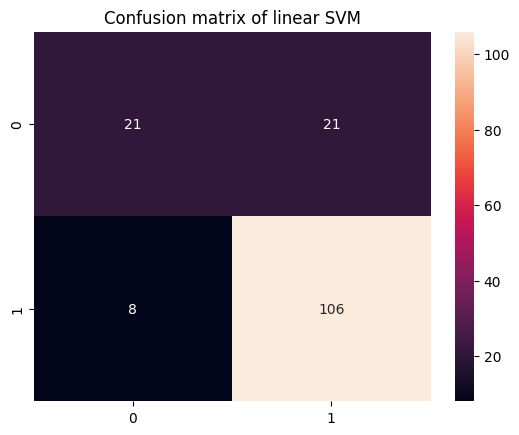

In [38]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test,grid_predictions)
sns.heatmap(cm, annot=True, fmt='d').set_title('Confusion matrix of linear SVM') # fmt='d' formats the numbers as digits, which means integers

print(classification_report(y_test,grid_predictions))

In [39]:
clf = grid.best_estimator_
clf.get_params()
print(clf.n_support_)

[120 155]


In [40]:
# get the actual output of SVM
decision_function = clf.decision_function(X_test)
print(decision_function)

[ 0.34222436  1.24815097  2.31435679  0.92933468  2.09767295  1.09332679
 -2.35593577  1.07007919  1.82247295  1.42776632 -0.80065422 -0.43131614
  0.04006296  0.78035768  1.15038274  0.86873592  0.94070022  1.43222493
  2.19794176 -0.1681608  -0.88767575  1.01708668  0.90307766 -0.50181117
 -2.50848372  0.14658678 -0.92527981  2.13711637  1.35058783  2.82236587
  1.30713533  2.24318755  3.00131394  0.35069045  1.72273516  0.40165799
  1.1928624   1.3135269  -0.97679986  2.71542926  0.85031721  0.05626962
  0.33811887  1.51749613  1.09041364 -0.60956441  1.3570063   1.58451743
  1.79549375  0.99986546  2.24615035  2.00217966  1.11523824  2.11103495
  1.04380336 -0.56291188  1.34639479  1.49823261 -2.14645847  1.61927094
  0.74842537  1.2478888   1.91927639 -0.87281142  2.36748089  1.00723545
  2.29747515  0.84618055  1.58745482  0.41879364  2.0968641   1.44523828
  1.46703009  2.79000533 -0.080372    1.21608587 -0.76731224 -0.49006018
  0.57225355  1.65207234  1.52259117  0.94622305  1

In [41]:
import numpy as np
print("svc.gamma: ", clf._gamma)
print("svc.degree: ", clf.degree)

sv=open("../data-kernel-model-rbf/support_vectors_rbf.txt","w")
dual_coeff=open("../data-kernel-model-rbf/dual_coeff_rbf.txt","w")
intercept=open("../data-kernel-model-rbf/intercept_rbf.txt","w")
xtestSample="../data-kernel-model-rbf/xtest_rbf.txt"
ytestSample="../data-kernel-model-rbf/ytest_rbf.txt"
ytestClassificationScore="../data-kernel-model-rbf/yclassificationscore.txt"
gammaValue="../data-kernel-model-rbf/gamma.txt"

np.savetxt(sv,clf.support_vectors_)
    
np.savetxt(dual_coeff,clf.dual_coef_,delimiter=' ')
np.savetxt(intercept,clf.intercept_,delimiter=' ')

with open(xtestSample, "w") as f1:
    for item in X_test[0]:  # Access the first row directly
        f1.write(str(item) + " ")
        
with open(ytestClassificationScore, "w") as f2:
    f2.write(str(decision_function[0]))
    
with open(ytestSample, "w") as f3:
    f3.write(str(y_test[0]))
    
with open(gammaValue, "w") as f4:
    f4.write(str(clf._gamma))
    
sv.close()
dual_coeff.close()
intercept.close()
f1.close()
f2.close()
f3.close()
f4.close()

svc.gamma:  0.1
svc.degree:  3


In [42]:
print(str(clf._gamma))
print(str(clf.intercept_))

0.1
[-5.96997429]


In [43]:
print(clf.support_vectors_[0].shape)

(64,)
